Ep: 50 - Loss: 0.197 - Val Loss:0.223 
Ep: 100 - Loss: 0.164 - Val Loss:0.207 
Ep: 150 - Loss: 0.153 - Val Loss:0.2 
Ep: 200 - Loss: 0.146 - Val Loss:0.199 
Ep: 250 - Loss: 0.139 - Val Loss:0.197 
Ep: 300 - Loss: 0.133 - Val Loss:0.198 
Ep: 350 - Loss: 0.13 - Val Loss:0.199 
Ep: 400 - Loss: 0.125 - Val Loss:0.2 
Ep: 450 - Loss: 0.122 - Val Loss:0.204 
Ep: 500 - Loss: 0.124 - Val Loss:0.205 

R2 Score: 0.8895672631318604


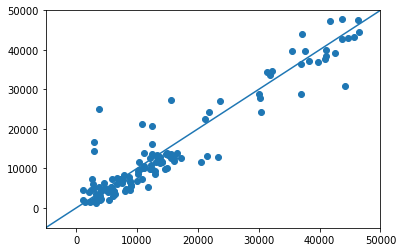

In [118]:
"""
An Implementation of the method Neural Ordinary Differential 
Equation presented in: https://arxiv.org/abs/1806.07366


TODO: 

- implement a neural ODE


NOTES:
- 

LINKS:

- nice ref:
https://github.com/msurtsukov/neural-ode/blob/master/Neural%20ODEs.ipynb

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
Initialse the model parameters.
"""
def init_weights(layers, skips=[], scale=1.0, seed=0):
    
    # set the seed and create the weights
    rng = np.random.RandomState(seed)
    weights = [(scale * rng.randn(m, n), scale * rng.randn(n).reshape(1, -1)) for m, n in zip(layers[:-1], layers[1:])]
    skip_weights = [None] * len(weights)    
    
    # create the skip weights
    if len(skips) > 0:
        skip_start, skip_stop = zip(*skips)
        for idx in range(len(skips)):

            # check the skips
            cond1, cond2 = (skip_stop[idx] - skip_start[idx] > 1), (skip_start[idx] > 0)
            cond3, cond4 = (skip_stop[idx] < len(weights)), (skip_stop[idx] < np.array(skip_start[idx + 1:])).all()
            assert (cond1 & cond2 & cond3 & cond4), "Invalid skip settings."

            # add skip
            n, m = weights[skip_start[idx]][0].shape[0], weights[skip_stop[idx] - 1][0].shape[1]
            skip_weights[skip_stop[idx] - 1] = scale * rng.rand(n, m)
    
    return weights, skip_weights

"""
A basic residual neural network model set up so that 
skips are performed between layers of equal dimensions.
"""
class residual_NN:    
    def __init__(self, layers, skips=[], seed=0):
        
        # intialise the parameters
        self.weights, self.skip_weights = init_weights(layers, skips, scale=0.3, seed=seed)
        self.skip_start, self.skip_stop = zip(*skips) if len(skips) > 0 else [], []
        self.A = []
        
        # hyperparams
        self.lr = 1e-3
        self.lamba = 0.0
    
    """
    Get the forward prediction of shape (batch_size, state_dim)
    """
    def __call__(self, X):     
        
        A_log = [X]
        skip_start_log, skip_end_log = [None] * len(self.weights), [None] * len(self.weights)
        for idx, (w, b) in enumerate(self.weights):    
                        
            # linear + activation
            Z = np.dot(X, w) + b        
            A = np.tanh(Z) 
            
            # log hidden states
            A_log.append(A)
            
            # handle the skips layer
            if (idx + 1) in self.skip_start: skip_start_log[idx] = A
            if (idx + 1) in self.skip_stop: 
                start_idx = self.skip_start[self.skip_stop.index(idx + 1)]                   
                A_skip = np.dot(skip_start_log[start_idx - 1], self.skip_weights[idx])
                skip_end_log[idx] = A_skip
                A += A_skip    
            
            # move to next layer
            X = A
        
        # set intermediate states
        self.A = A_log[:-1] + [Z]
        self.A_skip_start, self.A_skip_end = skip_start_log, skip_end_log
        
        return Z   
    
    """
    Update the model weights.
    """
    def step(self, Y):
        
        skip_log = []
        for idx, (w, b) in reversed(list(enumerate(self.weights))):
            
            # compute the cost function
            N = Y.shape[0]
            if idx == (len(self.weights) - 1):                
                dz = np.sum(self.A[idx+1] - Y, axis=1, keepdims=True) 
                dw = (2/N) * np.dot(self.A[idx].T, dz) + (2/N) * (w * self.lamba)
                db = (2/N) * np.sum(dz, axis=0)                
                self.weights[idx] = (w - dw * self.lr, b - db * self.lr)                
                continue
            
            # update the hidden layers               
            dz_prev = dz
            dz = (1 - np.square(np.tanh(self.A[idx+1]))) * np.dot(dz, self.weights[idx+1][0].T) 
            
            # handle the skip
            if (idx + 2) in self.skip_start: dz += skip_log[-1]
            if (idx + 2) in self.skip_stop:                   
                dz_s = np.dot(dz_prev, self.skip_weights[idx + 1].T)                                
                dw_s = (1/N) * np.dot(self.A_skip_end[idx + 1].T, dz_s)                
                curr_ws = self.skip_weights[idx + 1]
                self.skip_weights[idx + 1] = curr_ws - (dw_s.T * self.lr)   
                skip_log.append(dz_s)                
            
            dw = (1/N) * np.dot(self.A[idx].T, dz) + (2/N) * (w * self.lamba)         
            db = (1/N) * np.sum(dz, axis=0)
            self.weights[idx] = (w - dw * self.lr, b - db * self.lr)            
            
"""
Simple Mean-Squared Error Loss
"""
def mse_loss(true, pred):   
    return np.mean(np.sum(np.square(true - pred), axis=1))

"""
Calculate the R2 score for the model. 
"""
def R2_score(true, pred):    
    ssr = np.sum(np.square(pred - true))
    sst = np.sum(np.square(pred - np.mean(true)))
    return 1 - ssr/sst

"""
Run the training loop for the residual model.
"""
def train_model(model, dataset, loss_func, epochs=10, batch_size=32, seed=0):
    
    rng = np.random.RandomState(seed)
    train, val = dataset[0], dataset[1]    
    for ep in range(epochs):
        
        # shuffle the datasets
        rng.shuffle(train)
        rng.shuffle(val)        
        
        losses = []
        iters = int(len(train) // batch_size) + 1 
        for it in range(iters):
            
            # get a batch of data            
            x_tr = train[it * batch_size: min((it + 1) * batch_size, len(train)), :-1]            
            y_tr = train[it * batch_size: min((it + 1) * batch_size, len(train)), -1]
                        
            # get the prediction            
            y_pred = model(x_tr)
        
            # calculate the loss
            reg_loss = model.lamba * np.sum([np.sum(np.square(w)) for w, _ in model.weights])
            loss = loss_func(y_tr.reshape(-1, 1), y_pred) + reg_loss
            
            # track losses
            losses.append(loss)
            
            # update the weights 
            model.step(y_tr.reshape(-1, 1))
            
        # get validation loss
        x_val, y_val = val[:, :-1], val[:, -1]            
        y_val_pred = model(x_val)
        reg_loss = model.lamba * np.sum([np.sum(np.square(w)) for w, _ in model.weights])
        val_loss = loss_func(y_val.reshape(-1, 1), y_val_pred) + reg_loss
        
        # display loss
        if (ep + 1) % (epochs // 10) == 0:
            print('Ep: {} - Loss: {} - Val Loss:{} '.format(ep + 1, round(np.mean(losses), 3), round(val_loss, 3)))    


# load in the dataset
dataset = pd.read_csv("./Data/insurance_train.csv")
seed = 10000

# convert columns to categorical
dataset["sex"] = dataset["sex"].astype('category')
dataset["region"] = dataset["region"].astype('category')
dataset["smoker"] = dataset["smoker"].astype('category')

# get the categorical columns
cat_columns = dataset.select_dtypes(['category']).columns
dataset[cat_columns] = dataset[cat_columns].apply(lambda x: x.cat.codes)

# convert to a numpy array and normalise
array = dataset.to_numpy()
mean, std = np.mean(array, axis=0), np.std(array, axis=0)
array = (array - mean) / std

# shuffle array and get split
rng = np.random.RandomState(seed)
rng.shuffle(array)
train_s, val_s, test_s = round(0.8 * len(array)), round(0.1 * len(array)), round(0.1 * len(array)) 
train, val, test = array[:train_s, :], array[train_s:(train_s+val_s), :], array[-test_s:, :]

# NOTE: ---------------------------------------------------------------

# layers: 60, 30, 20, 40
# (1, 3) -> output of 60 node layer appended to output of 20 node layer 

# ---------------------------------------------------------------------

# instantiate the model
x_dim, y_dim = train.shape[1] - 1, 1 
model = residual_NN(
    layers=[x_dim, 32, 32, 32, 32, 32, 32, 32, y_dim],
    skips=[(1, 3), (4, 6)],
    seed=seed
)

# train the model
train_model(
    model=model,
    dataset=(train, val),
    loss_func=mse_loss,
    batch_size=32,
    epochs=500
)

# test the accuracy of the model
y_test, x_test = test[:, -1], test[:, :-1] 
y_pred = model(x_test)

# unnorm the data
y_pred = y_pred * std[-1] + mean[-1]
y_test = y_test * std[-1] + mean[-1]

print('\nR2 Score: {}'.format(R2_score(pred=y_pred, true=y_test.reshape(-1, 1))))

# plot the resutls
plt.scatter(y_pred, y_test)
plt.plot([-10_000, 60_000], [-10_000, 60_000])
plt.xlim([-5_000, 50_000])
plt.ylim([-5_000, 50_000])
plt.show()


In [17]:


# reference: https://github.com/msurtsukov/neural-ode/blob/master/Neural%20ODEs.ipynb

import numpy as np
import math

"""
Initialse the model parameters.
"""
def init_weights(layers, scale=1.0, seed=0):
    
    # set the seed and create the weights
    rng = np.random.RandomState(seed)
    weights = [(scale * rng.randn(m, n), scale * rng.randn(n).reshape(1, -1)) for m, n in zip(layers[:-1], layers[1:])]
            
    return weights

"""
A simple feed-forward neural network model to 
approximate the derivative.
"""
class feedforward_NN:
    def __init__(self, layers, scale=1.0, seed=0):        
        self.weights = init_weights(layers, scale=scale, seed=seed)
    
    """
    Get the forward prediction of shape (batch_size, state_dim)
    """
    def __call__(self, X, t):
        
        A_log = [X]
        for idx, (w, b) in enumerate(self.weights):    
                        
            # linear + activation
            Z = np.dot(X, w) + b        
            A = np.max(Z, 0) 
            
            # log hidden states
            A_log.append(A)
            
            # move to next layer
            X = A
        
        # set intermediate states
        self.A = A_log[:-1] + [Z]
        
        return Z
    
"""
Solve an ODE using the Euler Method.
"""
def euler_ode_solver(z0, t0, t1, f):
    
    # set the step size
    dt_max = 0.05
    n_max = np.max(np.abs(t1 - t0)/dt_max).astype(int)
    dt = (t1 - t0)/n_max
        
    # recursively calculate z
    z, t = z0, t0
    for i in range(n_max):
        z = z + dt * f(z, t)
        t += dt
    
    return z


class ODEF(nn.Module):
    
    #########################
        # TODO: clean this up!!!
        #########################
    
    
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

"""
Implementation of neural ordinary differential
equation model.
"""
class neural_ode:
    def __init__(self, layers, seed=0):
        
        # specify the functional approximator
        self.func = feedforward_NN(
            layers=layers, seed=seed
        )
        
        # set the saved tensors
    
    def __call__(self, z0, t):
                
        # get the dimensions
        batch_size, feat_num = z0.shape
        t_len = t.shape[0]
        
        # store the forward pass
        z = np.zeros((t_len, batch_size, feat_num))
        z[0, :, :] = z0
        
        # solve for the hidden state through across the trajectory
        for i_t in range(t_len - 1):
            z0 = euler_ode_solver(z0, t[i_t], t[i_t+1], self.func)
            z[i_t+1, :, :] = z0
                
        return z
    
    
    def step(self, dLdz):
        
        #########################
        # TODO: clean this up!!!
        #########################
        
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
    
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

    
    
model = neural_ode(
    layers=[1, 32, 32, 32, 1],
    seed=0
)

z = model(np.ones((32, 1)), np.arange(10))
print(z.shape)

(10, 32, 1)
